In [ ]:
!wget https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py

--2023-06-09 11:28:40--  https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13881 (14K) [text/plain]
Saving to: ‘helper_prabowo_ml.py’

helper_prabowo_ml.p 100%[===================>]  13.56K  --.-KB/s    in 0s      

2023-06-09 11:28:40 (107 MB/s) - ‘helper_prabowo_ml.py’ saved [13881/13881]



In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 98.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 125.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 95.7 MB/s eta 0:00:00


Importing necessary modules

In [ ]:
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_, remove_special_characters, remove_digits
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model


Loading Train, Test and Validation dataset

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Emotion/train.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
val = pd.read_csv("/content/drive/MyDrive/Emotion/test.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
test = pd.read_csv("/content/drive/MyDrive/Emotion/val.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')

Combining datasets into a dataframe

In [ ]:
df = pd.concat([train,val,test],axis=0)
df = df.sample(frac=0.1)
df = df.reset_index()
df.head()

,index,Input,Sentiment
0,12822,i feel like staying in a barn so carefree,joy
1,643,i feel most passionate about that arouse my em...,love
2,12516,i just like women you also feel this is his tr...,joy
3,242,i hope i feel mellow well fed well slept at pe...,joy
4,15461,im feeling pretty hopeful about the future of ...,joy


In [ ]:
df.drop('index',axis=1,inplace=True)
df.shape

(2000, 2)

Preprocessing

In [ ]:
def preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=lower)
    return data
    
preprocessed_df = preprocess(df,'Input')
preprocessed_df.head()


,Input,Sentiment
0,feel staying barn carefree,joy
1,feel passionate arouse emotions seem things ne...,love
2,women also feel truthful straightforwardness f...,joy
3,hope feel mellow well fed well slept peace wit...,joy
4,m feeling pretty hopeful future public service,joy


In [ ]:
preprocessed_df['num_words'] = preprocessed_df.Input.apply(len)
preprocessed_df.head()

,Input,Sentiment,num_words
0,feel staying barn carefree,joy,26
1,feel passionate arouse emotions seem things ne...,love,97
2,women also feel truthful straightforwardness f...,joy,62
3,hope feel mellow well fed well slept peace wit...,joy,64
4,m feeling pretty hopeful future public service,joy,46


In [ ]:
encoded_labels = {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5} 

In [ ]:
train_data, test_data = train_test_split(preprocessed_df,test_size=0.3,random_state=101,shuffle=True,stratify=preprocessed_df.Sentiment)

In [ ]:
train_data['Label'] = train_data.Sentiment.map(encoded_labels)
test_data['Label'] = test_data.Sentiment.map(encoded_labels)

In [ ]:
train_data.head()

,Input,Sentiment,num_words,Label
216,randomly heard ever since watching video delig...,joy,81,2
628,already going feel giggly,joy,25,2
238,feel groggy today tired,sadness,23,4
805,posted feeling super mom managed care children...,joy,88,2
1820,m feeling insecure financially right dont want...,fear,52,1


In [ ]:
test_data.head()

,Input,Sentiment,num_words,Label
1992,feel romantic feelings soul begging god make u...,love,138,3
679,guess feel little vulnerable undergo physical ...,fear,93,1
857,always feel overwhelmed mixture feelings liste...,surprise,56,5
400,seem lost sense direction feel doomed get crap...,sadness,96,4
1841,feel ive become relaxed parent,joy,30,2


Loading Tokenizer class and pre-trained BERT transformer model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Tokenization

In [ ]:
max_len=40
X_train = tokenizer(text=train_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

X_test = tokenizer(text=test_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding='max_length',
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                  )

Model Architecture

In [ ]:
input_ids = Input(shape=(max_len,),name='input_ids',dtype=tf.int32)
attention_mask = Input(shape=(max_len,),name='attention_mask',dtype=tf.int32)

In [ ]:
embeddings = bert_model(input_ids,attention_mask=attention_mask)[0]
output = GlobalMaxPool1D()(embeddings)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.1)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=32,activation='relu')(output)
y = Dense(units=6,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=y)
model.layers[2].trainable = True

Compiling Model

In [ ]:
model.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=5e-5, epsilon=1e-8, clipnorm=1.0),
    metrics=[CategoricalAccuracy('balanced_accuracy')]
)


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 40)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 40,                                          

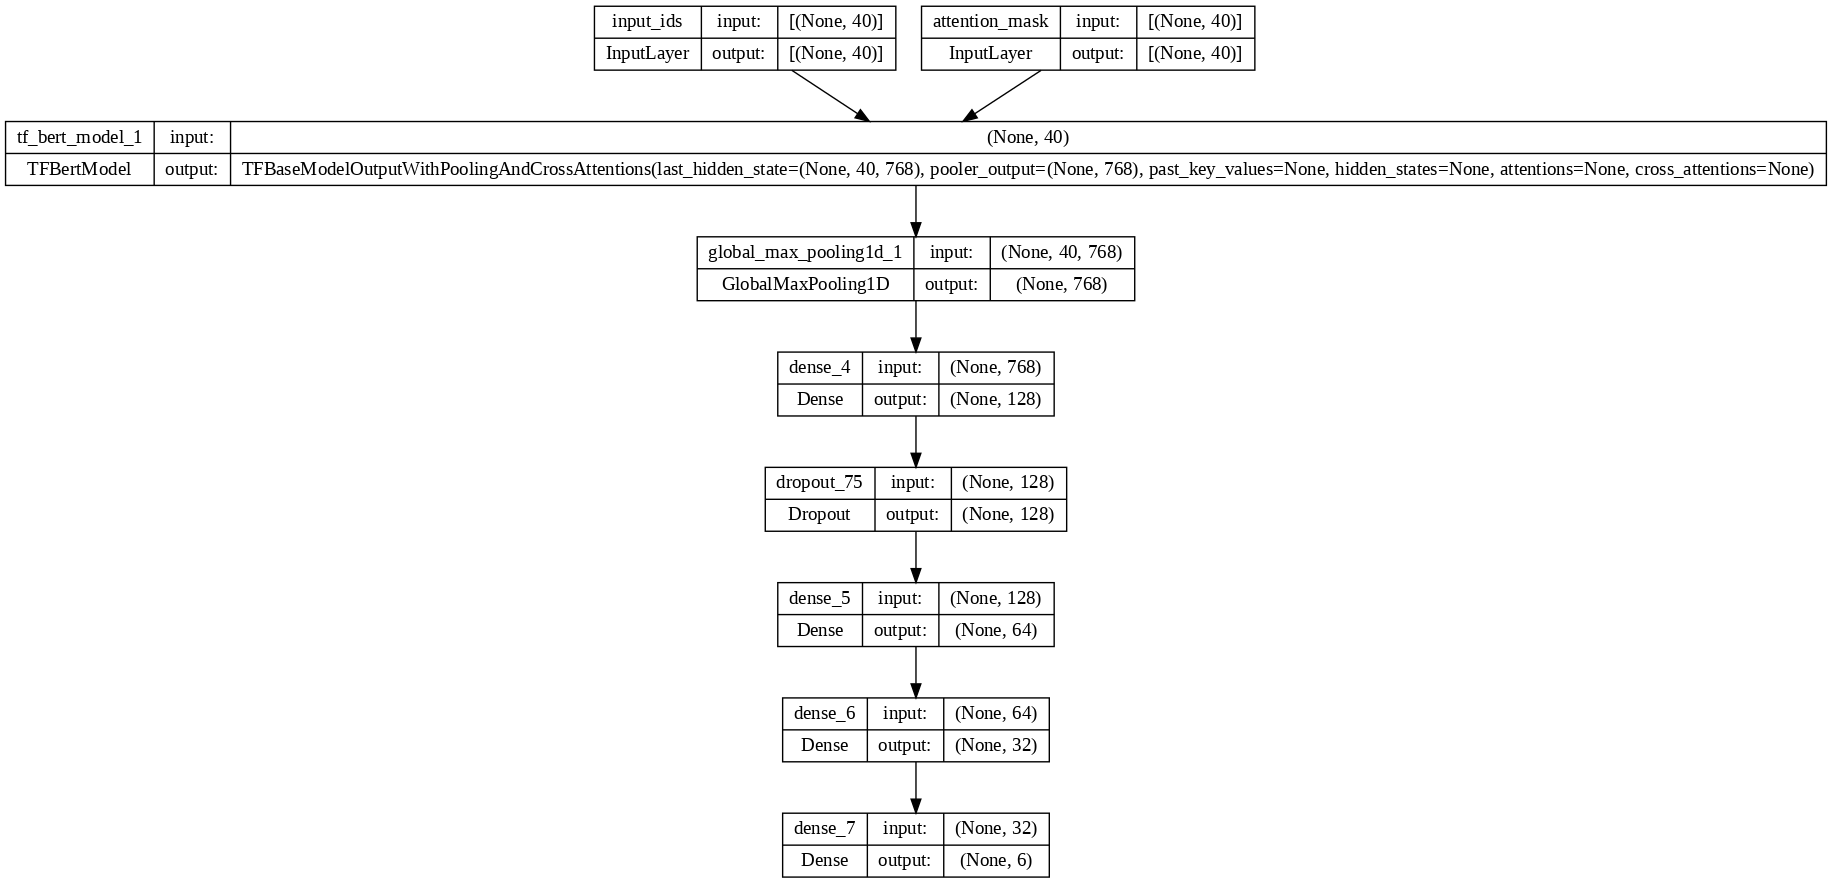

In [ ]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

Training Model

In [ ]:
hist= model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=to_categorical(train_data.Label),
             epochs=10,
             batch_size=32,
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
             )

Epoch 1/10


44/44 [==============================] - 83s 540ms/step - loss: 1.5622 - balanced_accuracy: 0.4250 - val_loss: 1.2972 - val_balanced_accuracy: 0.5283
Epoch 2/10
44/44 [==============================] - 18s 406ms/step - loss: 1.1485 - balanced_accuracy: 0.5814 - val_loss: 0.9067 - val_balanced_accuracy: 0.6833
Epoch 3/10
44/44 [==============================] - 18s 404ms/step - loss: 0.6288 - balanced_accuracy: 0.7936 - val_loss: 0.5790 - val_balanced_accuracy: 0.8117
Epoch 4/10
44/44 [==============================] - 16s 369ms/step - loss: 0.2944 - balanced_accuracy: 0.9136 - val_loss: 0.5071 - val_balanced_accuracy: 0.8617
Epoch 5/10
44/44 [==============================] - 15s 337ms/step - loss: 0.1594 - balanced_accuracy: 0.9536 - val_loss: 0.5039 - val_balanced_accuracy: 0.8600
Epoch 6/10
44/44 [==============================] - 17s 387ms/step - loss: 0.1087 - balanced_accuracy: 0.9750 - val_loss: 0.5047 - val_balanced_accuracy: 0.8750
Epoch 7/10
44/44 [===========================

Analyzing Performance

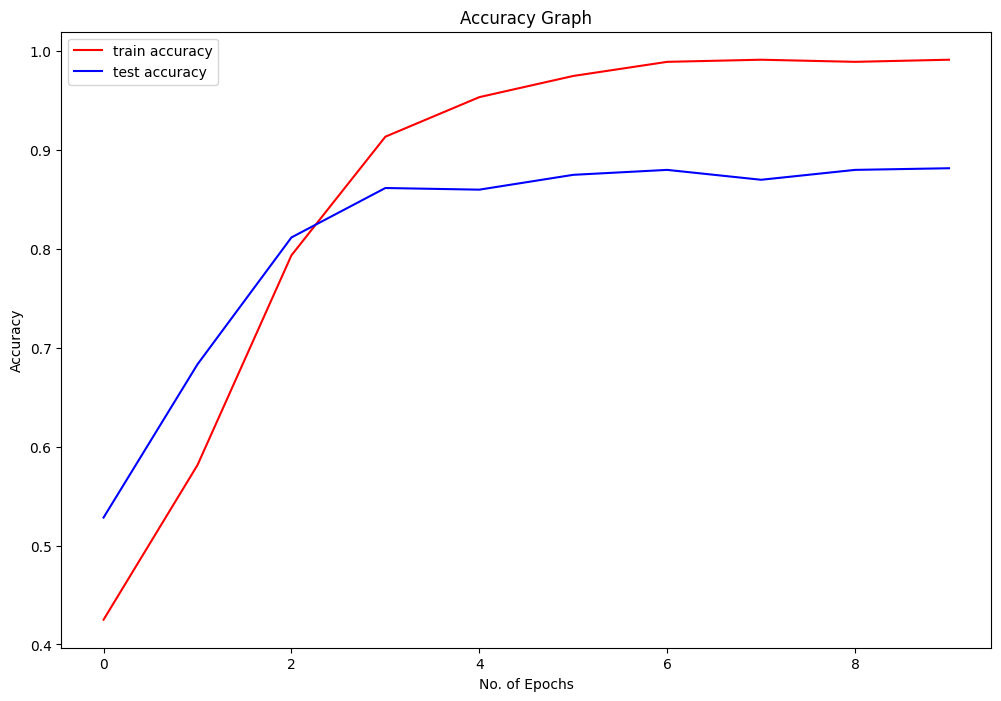

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(hist.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [ ]:
model.save("emotion_detector.h5")

In [ ]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
print("Test Categorical Cross-Entropy Loss:",loss)
print("Test Categorical Accuracy:",acc)

19/19 [==============================] - 2s 94ms/step - loss: 0.6117 - balanced_accuracy: 0.8817
Test Categorical Cross-Entropy Loss: 0.6117256879806519
Test Categorical Accuracy: 0.8816666603088379


In [ ]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print(classification_report(test_data.Label,test_predictions))

19/19 [==============================] - 2s 90ms/step
              precision    recall  f1-score   support

           0       0.97      0.85      0.90        84
           1       0.79      0.76      0.78        68
           2       0.88      0.95      0.91       202
           3       0.84      0.70      0.76        53
           4       0.94      0.92      0.93       173
           5       0.64      0.90      0.75        20

    accuracy                           0.88       600
   macro avg       0.84      0.85      0.84       600
weighted avg       0.89      0.88      0.88       600

